## 📌 1. Импорты и подготовка среды

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


## 📁 2. Загрузка данных

In [3]:

train_path = "train.csv"
test_path = "test.csv"
submission_path = "sample_submission.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (600000, 15)
Test shape: (400000, 14)


,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0


## 🧹 3. Предобработка данных

In [4]:

print(train.isnull().sum())

train['chest'] = train['chest'].round().astype(int)
test['chest'] = test['chest'].round().astype(int)

print(train.dtypes)

categorical = ['sex', 'chest', 'fasting_blood_sugar', 
               'resting_electrocardiographic_results',
               'exercise_induced_angina', 'slope', 
               'number_of_major_vessels', 'thal']

train = pd.get_dummies(train, columns=categorical)
test = pd.get_dummies(test, columns=categorical)

y = train['class']
X = train.drop(['ID', 'class'], axis=1)
X_test = test.drop(['ID'], axis=1)


ID                                      0
age                                     0
sex                                     0
chest                                   0
resting_blood_pressure                  0
serum_cholestoral                       0
fasting_blood_sugar                     0
resting_electrocardiographic_results    0
maximum_heart_rate_achieved             0
exercise_induced_angina                 0
oldpeak                                 0
slope                                   0
number_of_major_vessels                 0
thal                                    0
class                                   0
dtype: int64
ID                                        int64
age                                     float64
sex                                       int64
chest                                     int64
resting_blood_pressure                  float64
serum_cholestoral                       float64
fasting_blood_sugar                       int64
resting_electrocardio

## 📊 4. Анализ данных

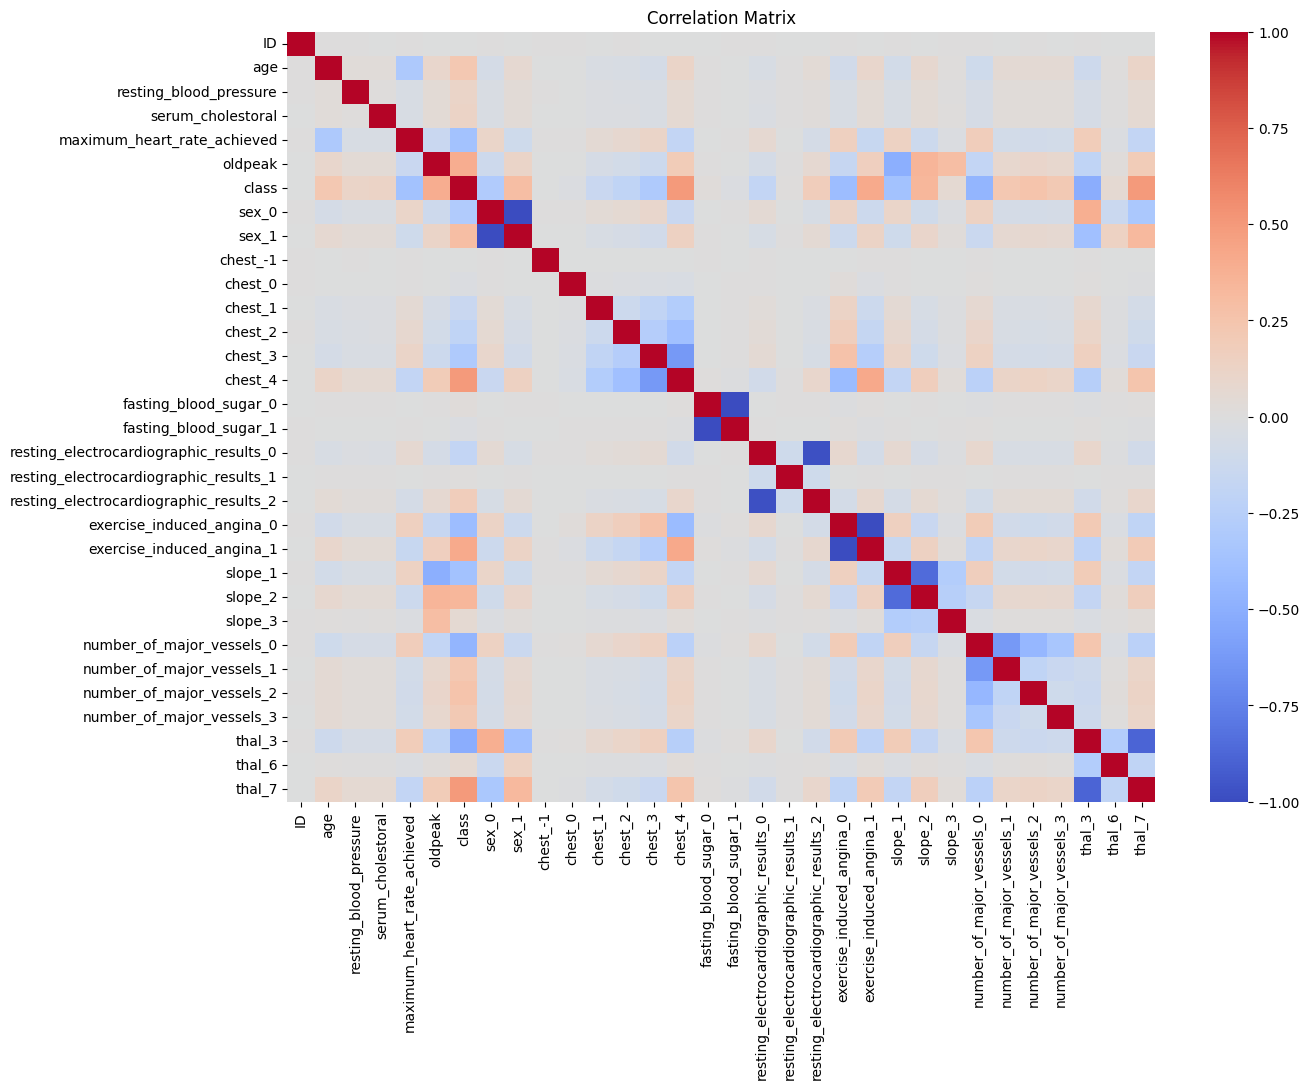

In [5]:

plt.figure(figsize=(14, 10))
corr = train.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


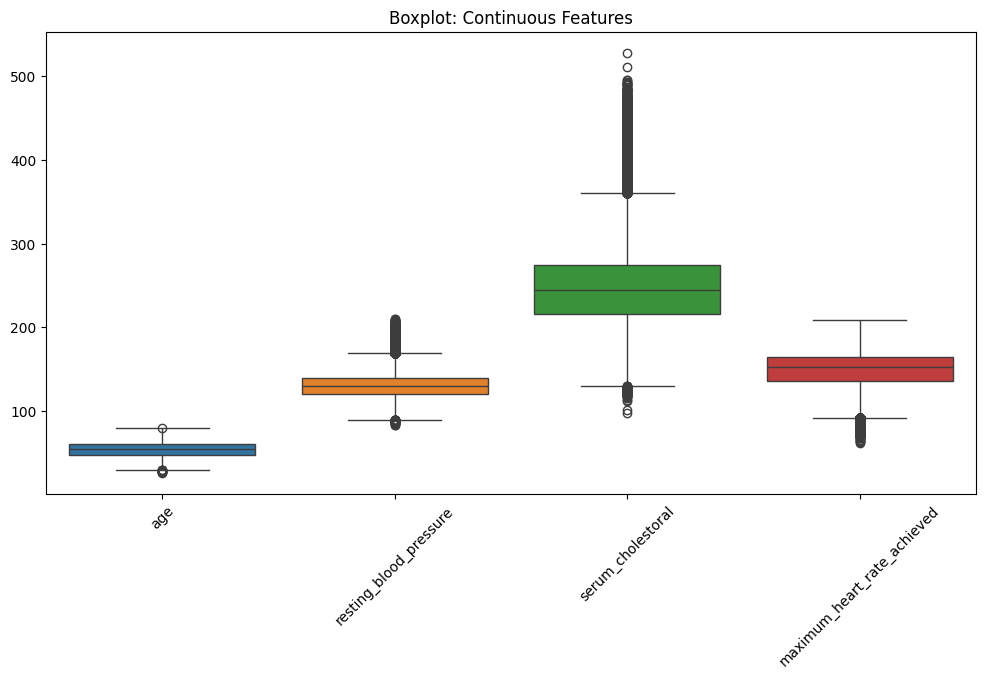

In [6]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=train[['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved']])
plt.title("Boxplot: Continuous Features")
plt.xticks(rotation=45)
plt.show()


## 🤖 5.1 Logistic Regression

In [7]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_pred))


Logistic Regression Accuracy: 0.88825
ROC AUC: 0.8857709460879231


## 🤖 5.2 Random Forest

In [8]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_pred_rf))


Random Forest Accuracy: 0.895575
ROC AUC: 0.8931925553905632


## 🤖 5.3 Нейросеть (PyTorch)

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Приведение признаков и целевой переменной к float32
X = X.astype(np.float32)
y = y.astype(np.float32)

# Тензоры и загрузчик данных
dataset = TensorDataset(torch.tensor(X.values), torch.tensor(y.values))
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Определение модели
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X.shape[1], 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Инициализация модели, функции потерь и оптимизатора
model = Net()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Обучение
for epoch in range(10):
    for xb, yb in loader:
        pred = model(xb).squeeze()
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

import os
os.makedirs("models", exist_ok=True)

# Сохранение весов
torch.save(model.state_dict(), "models/neural_net.pt")



Epoch 1: Loss = 0.2420
Epoch 2: Loss = 0.2631
Epoch 3: Loss = 0.2783
Epoch 4: Loss = 0.2913
Epoch 5: Loss = 0.2463
Epoch 6: Loss = 0.2666
Epoch 7: Loss = 0.2362
Epoch 8: Loss = 0.2686
Epoch 9: Loss = 0.2299
Epoch 10: Loss = 0.2761
